<a href="https://colab.research.google.com/github/swilsonmfc/anomaly/blob/master/AnomalyDeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anomaly Detection with Deep Learning
![alt text](https://miro.medium.com/max/922/0*ll8GqXcuJi-Lv-Am)

# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import LSTM

from tensorflow.keras.callbacks import EarlyStopping

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
tf.__version__

'2.3.0'

# Data

In [3]:
!git clone https://github.com/swilsonmfc/anomaly

Cloning into 'anomaly'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 78 (delta 31), reused 21 (delta 7), pack-reused 0
Unpacking objects: 100% (78/78), done.


In [4]:
cd anomaly

/content/anomaly


In [5]:
ls data

data_anomaly_ecoli.csv         data_anomaly_shuttle_train.csv
data_anomaly_shuttle.csv       data_anomaly_speech.csv
data_anomaly_shuttle_test.csv  data_anomaly_taxi.csv


In [6]:
taxi_df = pd.read_csv('data/data_anomaly_taxi.csv')

# EDA

In [7]:
taxi_df.head()

,TIMESTAMP,VALUE,OUTLIER
0,2014-07-01 00:00:00,10844,0
1,2014-07-01 00:30:00,8127,0
2,2014-07-01 01:00:00,6210,0
3,2014-07-01 01:30:00,4656,0
4,2014-07-01 02:00:00,3820,0


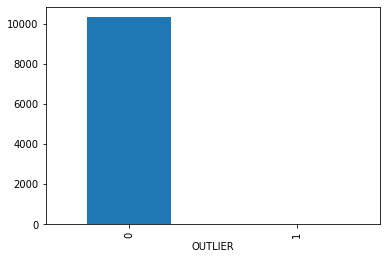

In [8]:
taxi_df.groupby('OUTLIER').size().plot.bar()

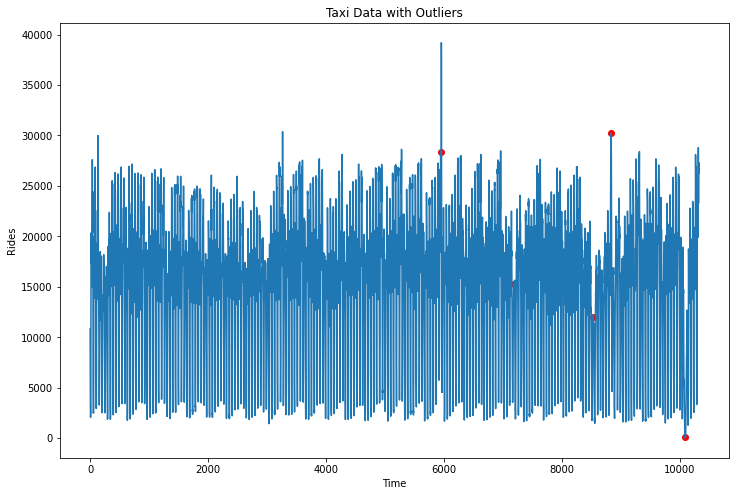

In [9]:
taxi_df['VALUE'].plot(figsize=(12,8))
outliers_df = taxi_df[taxi_df.OUTLIER == 1]
plt.scatter(outliers_df.index, outliers_df.VALUE, color='red');
plt.xlabel('Time')
plt.ylabel('Rides')
plt.title('Taxi Data with Outliers');

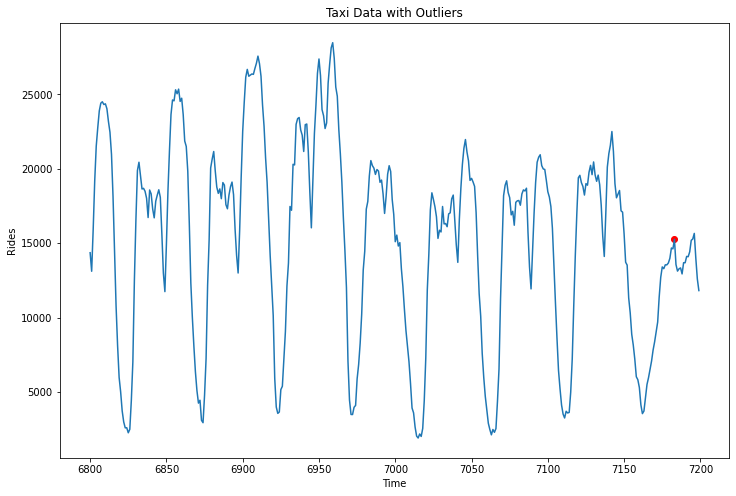

In [10]:
subset_df = taxi_df[6800:7200]
subset_df['VALUE'].plot(figsize=(12,8))
outliers_df = subset_df[subset_df.OUTLIER == 1]
plt.scatter(outliers_df.index, outliers_df.VALUE, color='red');
plt.xlabel('Time')
plt.ylabel('Rides')
plt.title('Taxi Data with Outliers');

# Helpers

In [11]:
def plot_outliers(X, test, pred):
  df = X.copy()
  df['OUTLIER'] = test
  df['PRED']    = pred
  
  df['VALUE'].plot(figsize=(12,8))

  outliers_df = df[df.OUTLIER == 1]
  plt.scatter(outliers_df.index, outliers_df.VALUE, color='red');
  outliers_df = df[(df.OUTLIER == 0) & (df.PRED == 1)]
  plt.scatter(outliers_df.index, outliers_df.VALUE, color='red', marker='x') 
  outliers_df = df[(df.OUTLIER == 1) & (df.PRED == 1)]
  plt.scatter(outliers_df.index, outliers_df.VALUE, color='green');
  
  plt.xlabel('Time')
  plt.ylabel('Rides')
  plt.title('Taxi Data with Outliers');

def evaluate_outliers(X, y, pred):
  plot_outliers(X, y, pred)
  plot_confusion(y, pred)
  print_classification_report(y, pred)

def print_classification_report(test, pred, target_names=['NORMAL', 'OUTLIER']):
  report = classification_report(test, pred, target_names=target_names)
  print(report)  

def plot_confusion(test, pred, class_names=['NORMAL', 'OUTLIER']):
  cm = confusion_matrix(test, pred)
  df = pd.DataFrame(cm, class_names, class_names)
  plt.figure(figsize=(10, 10))
  sns.heatmap(df, annot=True, fmt='d', cmap='BuGn')
  plt.xlabel('Prediction')
  plt.ylabel('Actual')
  plt.show()

def plot_roc_curve(test, pred_proba):
  fpr, tpr, _ = roc_curve(test,  pred_proba)
  auc = roc_auc_score(test, pred_proba)
  plt.figure(figsize=(10, 10))
  plt.plot(fpr, tpr, label=f'AUC = {auc}')
  plt.plot([0,1], [0,1], linestyle='--')
  plt.title('ROC Curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc=4)
  plt.show()

def plot_precision_recall_curve(test, pred_proba):
  precision, recall, _ = precision_recall_curve(test, pred_proba)
  aps = average_precision_score(y_test, pred_proba)
  plt.figure(figsize=(10, 10))
  plt.plot(recall, precision, label=f'Avg Precision = {aps}')
  plt.plot([0,1], [0.5,0.5], linestyle='--')
  plt.fill_between(recall, 0, precision)
  plt.title('Precision Recall Curve')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.legend(loc=4)
  plt.show()

# Preprocessing

In [12]:
X_train = taxi_df.copy()
y_train = X_train['OUTLIER'].copy()
X_train = X_train.drop(columns=['TIMESTAMP', 'OUTLIER'])

# Evaluation Metrics
## Regression
![alt text](https://1.bp.blogspot.com/-kL42RjXdOEc/XMELxXVMe3I/AAAAAAAABRw/mx2RoIheodwWj0CPAqg9chwXJmpOyPyJQCLcBGAs/s1600/Loss_Functions.PNG)

## Classification
* Accuracy
* Precision
* Recall

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/350px-Precisionrecall.svg.png)

# LSTM
* Take time series 
* Place a window on the data for training
  * Window is a subset of the data
* Determine the forecast window
  * Next step in sequence
  * Multiple steps
* Slide window
  * Stride is the number of steps to slide

![alt text](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2018/11/Sliding-Window-Approach-to-Modeling-Time-Series.png)

## Notes

## Recurrent Neural Network
* We pass each item in the sequence to our neural network
* To help us understand the series we keep a hidden state
* The hidden state is updated as we process the hidden state
* Our prediction is the final output
* We can take the sequence of outputs if we want to stack layers or desire all of the predictions
![alt text](https://miro.medium.com/max/800/1*JluFN2aG9VvHP0I7kFVLqw.png)

## Long Short Term Memory
* The recurrent network (RNN or Vanilla RNN) has several practical shortcomings
  * Exploding Gradient
  * Vanishing Gradient
* To compensate, we use an LSTM or GRU
* These have mechanisms to avoid gradient problems making learning stable

![alt text](https://upload.wikimedia.org/wikipedia/commons/6/63/Long_Short-Term_Memory.svg)

## Data Prep

In [13]:
lstm_df = taxi_df.copy()

## Pre-Processing
* Differencing
* Standardizing

In [14]:
lstm_df['DIFF'] = taxi_df.VALUE.diff(1)
lstm_df['DIFF'] = lstm_df.DIFF.fillna(0)

lstm_df['HOUR'] = pd.to_datetime(lstm_df.TIMESTAMP).dt.hour

scaler = StandardScaler()
lstm_df['SCALED'] = scaler.fit_transform(lstm_df[['VALUE']]).squeeze()

In [16]:
lstm_df.head()

,TIMESTAMP,VALUE,OUTLIER,DIFF,HOUR,SCALED
0,2014-07-01 00:00:00,10844,0,0.0,0,-0.618745
1,2014-07-01 00:30:00,8127,0,-2717.0,0,-1.010291
2,2014-07-01 01:00:00,6210,0,-1917.0,1,-1.286549
3,2014-07-01 01:30:00,4656,0,-1554.0,1,-1.510496
4,2014-07-01 02:00:00,3820,0,-836.0,2,-1.630971


## Series

In [18]:
def subseries(series, steps):
  X, y = [], []
  size = len(series)
  for index in range(size):
    if index + steps > size - 1:
      break
    seqX = series[index : index + steps][:]
    seqY = series[index + steps][0]
    X.append(seqX)
    y.append(seqY)
  return np.array(X), np.array(y).reshape(-1, 1)

def split_data(series, test_size=.5):
  observations = len(series)
  cut = int(observations * test_size)
  print(f'Splitting at {observations - cut}')
  training = series[ : observations - cut]
  test = series[observations - cut : ]
  return training, test

In [19]:
STEPS    = 48
FIELD    = ['SCALED', 'HOUR']
FEATURES = len(FIELD)

X, y = subseries(lstm_df[FIELD].values, steps=STEPS)
X = X.reshape(X.shape[0], STEPS, FEATURES)
print(X.shape, y.shape)

X_train, X_test = split_data(X)
y_train, y_test = split_data(y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(10272, 48, 2) (10272, 1)
Splitting at 5136
Splitting at 5136
(5136, 48, 2) (5136, 1)
(5136, 48, 2) (5136, 1)


## Model

In [20]:
model = keras.Sequential(   
  [
    LSTM(units=32, activation="relu", return_sequences=True, input_shape=(STEPS, FEATURES), dropout=0.2),
    LSTM(units=16, activation="relu", dropout=0.2),
    Dense(50),
    Dense(1)
  ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=3e-4), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 48, 32)            4480      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 50)                850       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 8,517
Trainable params: 8,517
Non-trainable params: 0
_________________________________________________________________


## Training

In [21]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
history = model.fit(X, y, 
                    batch_size=256,
                    epochs=200, 
                    verbose=1, 
                    validation_split = 0.1,
                    callbacks=[early_stop])

Epoch 1/200
37/37 [==============================] - 3s 75ms/step - loss: 0.6496 - val_loss: 0.6725
Epoch 2/200
37/37 [==============================] - 3s 68ms/step - loss: 0.4089 - val_loss: 0.5747
Epoch 3/200
37/37 [==============================] - 2s 65ms/step - loss: 0.3420 - val_loss: 0.5557
Epoch 4/200
37/37 [==============================] - 3s 68ms/step - loss: 0.3029 - val_loss: 0.5401
Epoch 5/200
37/37 [==============================] - 2s 64ms/step - loss: 0.2791 - val_loss: 0.5288
Epoch 6/200
37/37 [==============================] - 2s 65ms/step - loss: 0.2588 - val_loss: 0.6489
Epoch 7/200
37/37 [==============================] - 2s 67ms/step - loss: 0.2343 - val_loss: 0.5472
Epoch 8/200
37/37 [==============================] - 2s 65ms/step - loss: 0.2205 - val_loss: 0.5146
Epoch 9/200
37/37 [==============================] - 2s 67ms/step - loss: 0.2083 - val_loss: 0.4739
Epoch 10/200
37/37 [==============================] - 3s 69ms/step - loss: 0.1988 - val_loss: 0.4622

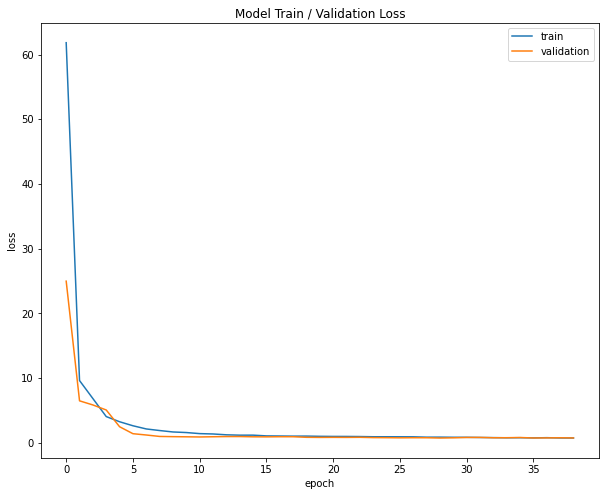

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Train / Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Test

In [22]:
y_pred = model.predict(X_test).squeeze()

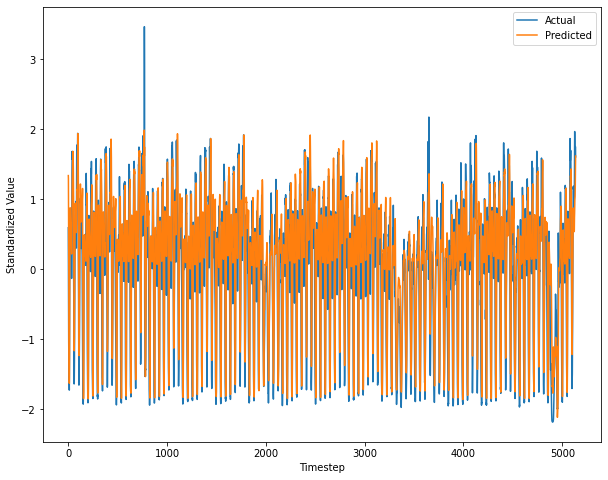

In [23]:
plt.figure(figsize=(10, 8))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.xlabel('Timestep')
plt.ylabel('Standardized Value');

Text(0, 0.5, 'Value')

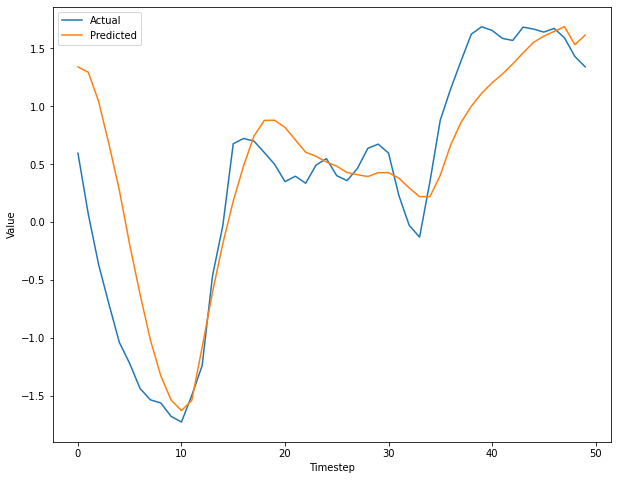

In [24]:
plt.figure(figsize=(10, 8))
plt.plot(y_test[:50], label='Actual')
plt.plot(y_pred[:50], label='Predicted')
plt.legend()
plt.xlabel('Timestep')
plt.ylabel('Value')

Text(0.5, 1.0, 'Residuals (Mean Error -0.2)')

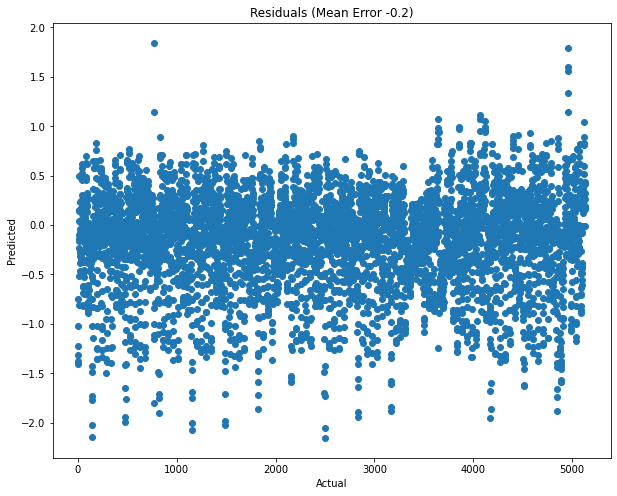

In [25]:
plt.figure(figsize=(10, 8))
plot_df = pd.DataFrame({'Predicted':y_pred, 'Actual':y_test.squeeze()}).reset_index()
plot_df['Residual'] = plot_df.Actual - plot_df.Predicted
plt.scatter(plot_df.index, plot_df.Residual)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Residuals (Mean Error {np.mean(plot_df.Residual):.1f})')

## Anomalies

# AutoEncoder
![alt text](https://images.squarespace-cdn.com/content/v1/590dd221579fb370d4adeaaf/1494168506258-UM4T4SI9YZ2JQ8VX88LT/ke17ZwdGBToddI8pDm48kHhRJWFsZ1aRqDZnU68Z4BhZw-zPPgdn4jUwVcJE1ZvWQUxwkmyExglNqGp0IvTJZamWLI2zvYWH8K3-s_4yszcp2ryTI0HqTOaaUohrI8PICu2Xfq4uRFOZcg1XG9OuDdV5M_p4HwLz0GBR0LdU5v4KMshLAGzx4R3EDFOm1kBS/image-asset.jpeg)

## Data Prep

In [26]:
ae_df = taxi_df.copy()

In [27]:
TIME_STEPS = 96

def create_sequences(values, time_steps=TIME_STEPS):
  output = []
  for i in range(len(values) - time_steps):
      output.append(values[i : (i + time_steps)])
  # Convert 2D sequences into 3D as we will be feeding this into
  # a convolutional layer.
  return np.expand_dims(output, axis=2).squeeze(-1)

def split_data(values, test_size=.5):
  observations = len(values)
  cut = int(observations * test_size)
  print(f'Splitting at {observations - cut}')
  training = values[ : observations - cut]
  test = values[observations - cut : ]
  return training, test

In [28]:
X_train, X_test = split_data(np.array(ae_df.VALUE).reshape(-1, 1))

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

Splitting at 5160


In [29]:
X_train = create_sequences(X_train)
X_test  = create_sequences(X_test)

print("Training input shape: ", X_train.shape)
print("Test     input shape: ", X_test.shape)

Training input shape:  (5064, 96, 1)
Test     input shape:  (5064, 96, 1)


## Model

In [32]:
class Conv1DTranspose(Layer):
  """
  Conv1DTranspose is only available in the TF Nightly build at this time
  You can reconstruct it with conv2dtranspose and squeezing the extra axis
  """
  def __init__(self, filters, kernel_size, strides=1, padding='valid', activation=None):
      super().__init__()
      self.conv2dtranspose = tf.keras.layers.Conv2DTranspose(
        filters = filters, 
        kernel_size = (kernel_size, 1), 
        strides = (strides, 1), 
        padding = padding, 
        activation = activation
      )

  def call(self, x):
      x = tf.expand_dims(x, axis=2)
      x = self.conv2dtranspose(x)
      x = tf.squeeze(x, axis=2)
      return x

In [33]:
model = keras.Sequential(   
  [
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    Conv1D(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
    Dropout(rate=0.2),
    Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
    Conv1DTranspose(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
    Dropout(rate=0.2),
    Conv1DTranspose(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
    Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
  ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 48, 32)            256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 48, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 24, 16)            3600      
_________________________________________________________________
conv1d_transpose_3 (Conv1DTr (None, 48, 16)            1808      
_________________________________________________________________
dropout_3 (Dropout)          (None, 48, 16)            0         
_________________________________________________________________
conv1d_transpose_4 (Conv1DTr (None, 96, 32)            3616      
_________________________________________________________________
conv1d_transpose_5 (Conv1DTr (None, 96, 1)            

## Training

In [34]:
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min", verbose=1)

history = model.fit(
    X_train,
    X_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[early_stop]
)

Epoch 1/50
36/36 [==============================] - 1s 36ms/step - loss: 0.4351 - val_loss: 0.1231
Epoch 2/50
36/36 [==============================] - 1s 33ms/step - loss: 0.1024 - val_loss: 0.0564
Epoch 3/50
36/36 [==============================] - 1s 32ms/step - loss: 0.0709 - val_loss: 0.0395
Epoch 4/50
36/36 [==============================] - 1s 33ms/step - loss: 0.0546 - val_loss: 0.0291
Epoch 5/50
36/36 [==============================] - 1s 33ms/step - loss: 0.0445 - val_loss: 0.0224
Epoch 6/50
36/36 [==============================] - 1s 32ms/step - loss: 0.0372 - val_loss: 0.0182
Epoch 7/50
36/36 [==============================] - 1s 33ms/step - loss: 0.0322 - val_loss: 0.0154
Epoch 8/50
36/36 [==============================] - 1s 33ms/step - loss: 0.0288 - val_loss: 0.0145
Epoch 9/50
36/36 [==============================] - 1s 34ms/step - loss: 0.0260 - val_loss: 0.0139
Epoch 10/50
36/36 [==============================] - 1s 33ms/step - loss: 0.0240 - val_loss: 0.0116
Epoch 11/

## Reconstruction

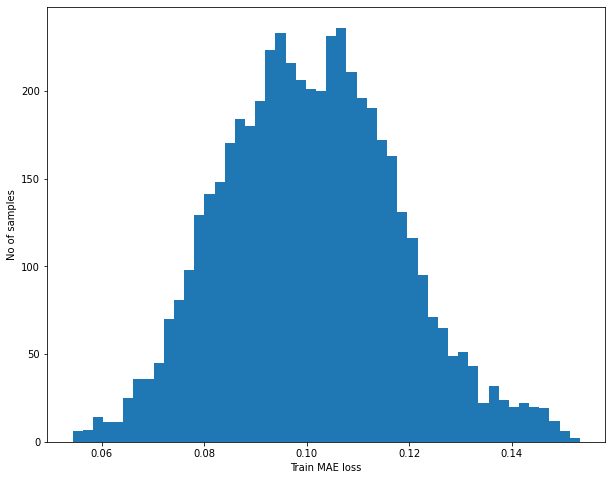

Reconstruction Error Threshold:  0.15324833245194955


In [35]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.figure(figsize=(10, 8))
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss) 
print("Reconstruction Error Threshold: ", threshold)

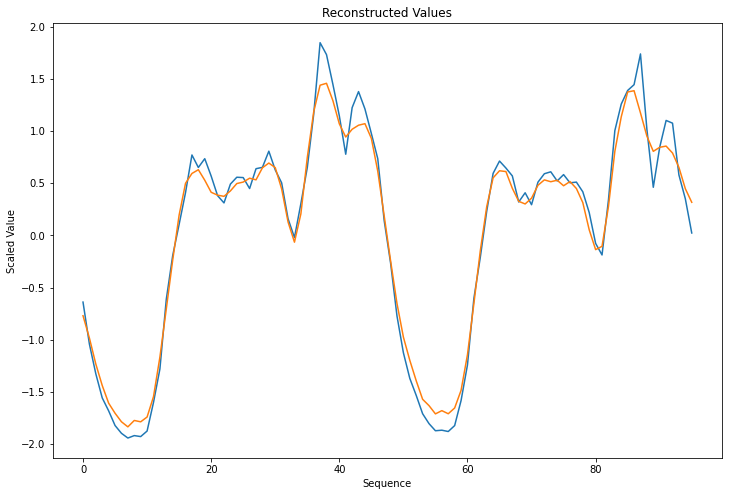

In [36]:
plt.figure(figsize=(12,8))
plt.plot(X_train[0], label='Actual')
plt.plot(X_train_pred[0], label='Predicted')
plt.title('Reconstructed Values')
plt.ylabel('Scaled Value')
plt.xlabel('Sequence')
plt.show()

## Test

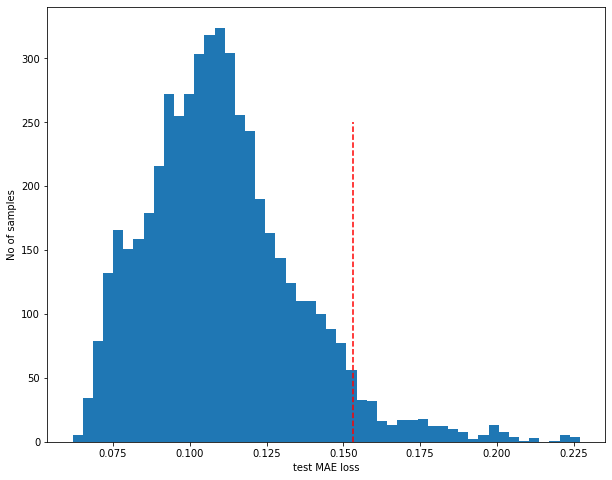

Number of anomaly samples:   249
Indices of anomaly samples: 
(array([  54,   58,   60,   62,   66,  699,  700,  701,  702,  703,  704,
        705,  706,  707,  708,  709,  710,  711,  712,  713,  714,  715,
        716,  717,  718,  719,  720,  721,  722,  723,  724,  725,  726,
        727,  728,  729,  730,  731,  732,  733,  734,  735,  736,  737,
        738,  739,  740,  741,  742,  743,  744,  745,  746,  747,  748,
        749,  750,  751,  752,  753,  754,  755,  756,  757,  758,  759,
        760,  761,  762,  763,  764,  765,  766,  767,  768,  769,  770,
        771,  772,  773,  774,  775,  776,  777,  778,  780,  781,  782,
        784,  786,  790, 1042, 1050, 1054, 1058, 1062, 1064, 1066, 1068,
       1070, 1398, 1402, 1404, 1405, 1406, 1714, 1718, 1722, 1726, 1730,
       1734, 1736, 1738, 1742, 2386, 2387, 2388, 2389, 2390, 2394, 2398,
       2399, 2400, 2401, 2402, 2403, 2404, 2405, 2406, 2407, 2408, 2409,
       2410, 2411, 2412, 2413, 2414, 2415, 2416, 2417, 2418, 

In [37]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.figure(figsize=(10,8))
plt.hist(test_mae_loss, bins=50)
plt.plot([threshold, threshold], [0, 250], '--', color='red')
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = (test_mae_loss > threshold).tolist()
print("Number of anomaly samples:  ",  np.sum(anomalies))
print("Indices of anomaly samples: ")
print(np.where(anomalies))

## Anomalous Series

In [44]:
# Strategy:  Does a point cause an anomaly in every series?
#anomaly_indices = []
#for data_idx in range(TIME_STEPS - 1, len(X_test) - TIME_STEPS + 1):
#    time_series = range(data_idx - TIME_STEPS + 1, data_idx)
#    if all([anomalies[j] for j in time_series]):
#        anomaly_indices.append(data_idx)

# Strategy:  Score the end point
#anomaly_indices = np.where(anomalies) 
#for index in anomaly_indices:
#  ae_df.at[len(X_train) + TIME_STEPS + index, 'SCORE'] = 1

# Strategy:  Flag the series
# For each point in the series, we want to flag the anomaly in the original dataframe
# Remember that test range starts at length of X_train + the time steps 
anomaly_indices = np.where(anomalies)
ae_df['SCORE'] = 0
TEST_START = len(X_train) + TIME_STEPS
for index in anomaly_indices:
  for series in index:
    for point in range(series, series + TIME_STEPS):
      ae_df.at[TEST_START + point, 'SCORE'] = 1

In [45]:
# Generate Avg Reconstruction Error
point_pred = np.abs(X_test_pred - X_test)

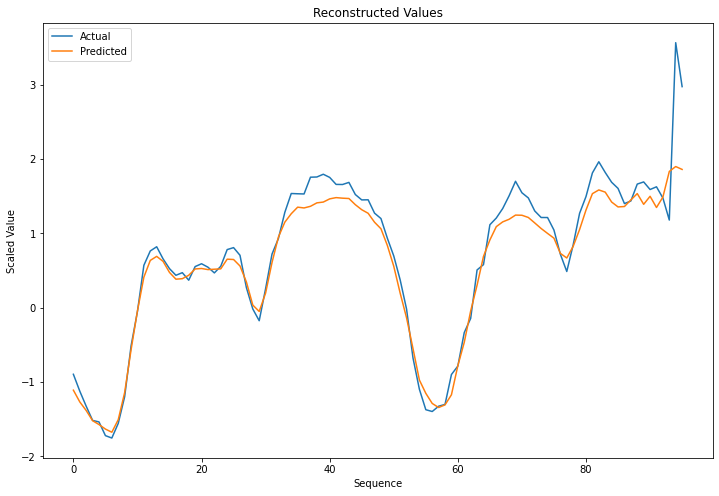

In [46]:
SERIES = 700

plt.figure(figsize=(12,8))
plt.plot(X_test[SERIES], label='Actual')
plt.plot(X_test_pred[SERIES], label='Predicted')
plt.title('Reconstructed Values')
plt.legend()
plt.ylabel('Scaled Value')
plt.xlabel('Sequence')
plt.show()

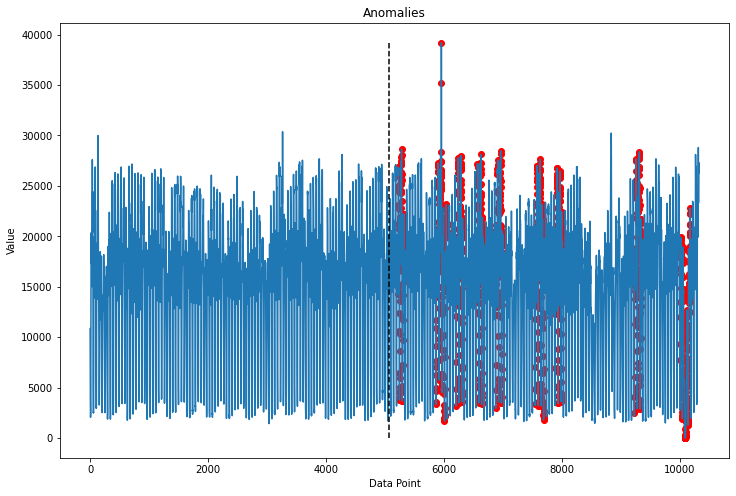

In [47]:
plt.figure(figsize=(12,8))
ae_df['VALUE'].plot()
plt.plot([len(X_train), len(X_train)], [0, ae_df.VALUE.max()], '--', color='black')
outlier_df = ae_df[ae_df.SCORE == 1]
outlier_df = outlier_df.reset_index()
plt.scatter(outlier_df['index'], outlier_df.VALUE, color='red')

plt.title('Anomalies')
plt.xlabel('Data Point')
plt.ylabel('Value');

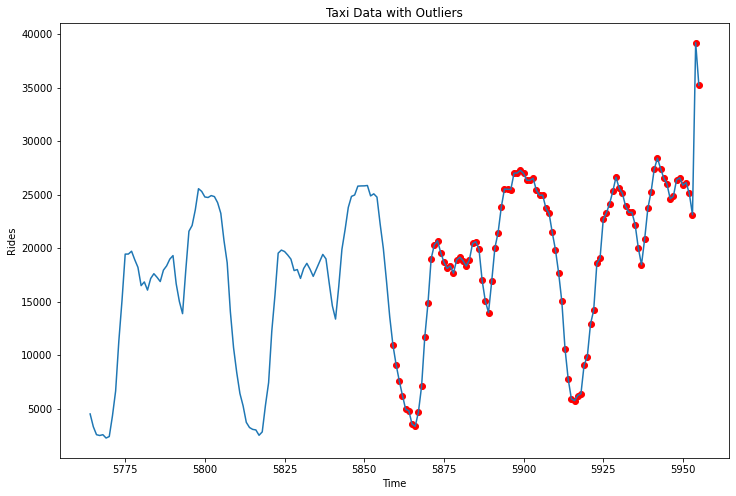

In [48]:
SERIES = 700
FROM, TO = len(X_train) + SERIES , len(X_train) + SERIES + TIME_STEPS * 2
plt.figure(figsize=(12,8))
plt.plot(ae_df['VALUE'][FROM:TO])
outliers_df = ae_df[FROM:TO][ae_df[FROM:TO].SCORE == 1]
plt.scatter(outliers_df.index, outliers_df.VALUE, color='red');
plt.xlabel('Time')
plt.ylabel('Rides')
plt.title('Taxi Data with Outliers');